In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
from scipy import interpolate as ip
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from astropy.io import ascii
from astropy.table import Table
from scipy.constants import c
from IPython.display import display, Math
from scipy.stats import gaussian_kde

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.io.fits as fits
from matplotlib.colors import LogNorm
from astropy.visualization import (
    imshow_norm,
    MinMaxInterval,
    ManualInterval,
    SqrtStretch,
    LogStretch,
    AsinhStretch,
)
from skimage.transform import resize

pd.set_option("display.max_columns", 400)
plt.rcParams.update({"font.size": 16})

In [2]:
#constants

L_sol = 3.83e26 #Watts

## Paths


In [3]:
cat_dirSK = "/net/virgo01/data/users/ebbers/BSc_Thesis/SKIRTOR/3-30SK/"
cat_dirF = "/net/virgo01/data/users/ebbers/BSc_Thesis/Fritz/3-30F/"

COSMOS_dirSK = "/net/virgo01/data/users/ebbers/BSc_Thesis/COSMOS/SKIRTOR/SK3-30/"
COSMOS_dirF= "/net/virgo01/data/users/ebbers/BSc_Thesis/COSMOS/Fritz/F3-30/"

sed_dirSK = cat_dirSK
sed_dirF = cat_dirF

cat_nameSK = "results_3-30SK.fits"
cat_nameF = "results_3-30F.fits"
#Ant_COSMOS_SK = "CIGALE_COSMOS2020_XRAY_FIR_COSMOS-Web_z_mass_chi_sel_cutouts.fits" #Antonio's results
COSMOS_nameSK = 'results_SK3-30.fits'
COSMOS_nameF = 'results_COSMOSF3-30.fits'

observations_fileSK = cat_dirSK + "observations_3-30SK.fits"
observations_fileF = cat_dirF + "observations_3-30F.fits"
COSMOS_observations_fileF = COSMOS_dirF + 'observations_COSMOSF3-30.fits'
COSMOS_observations_fileSK = COSMOS_dirSK + 'observations_SK3-30.fits'

In [4]:
IRlum_SK = pd.read_csv('IRlum_3-30SK.csv')

IRlum_SK = IRlum_SK.loc[IRlum_SK['redshift'] < 0.5]

#IRlum_ANT = pd.read_csv('IRlum_ANT.csv')

IRlum_COSMOSSK = pd.read_csv('IRlum_3-30SK_COSMOS.csv')

IRlum_SK = pd.concat([IRlum_SK, IRlum_COSMOSSK], ignore_index=True)

IRlum_SK

,id,redshift,IRLum_tot,fAGN_IR,fAGN_err,best_fAGN
0,3.989471e+16,0.340000,8.996002e+36,0.254797,0.241456,0.70
1,3.989485e+16,0.196839,3.124996e+36,0.176481,0.087811,0.10
2,3.989485e+16,0.400000,9.712273e+36,0.706946,0.095646,0.70
3,3.989498e+16,0.373100,1.472279e+37,0.331201,0.197466,0.40
4,3.989499e+16,0.430000,6.176537e+36,0.268682,0.262558,0.55
...,...,...,...,...,...,...
34626,9.643850e+05,2.415800,7.147979e+37,0.526794,0.377385,0.99
34627,9.643860e+05,1.306800,1.758638e+36,0.589256,0.208200,0.70
34628,9.643910e+05,2.898300,2.004169e+36,0.341509,0.283239,0.30
34629,9.644280e+05,1.258700,8.580657e+36,0.382373,0.157672,0.55


In [5]:
IRlum_F = pd.read_csv('IRlum_3-30F.csv')

IRlum_F = IRlum_F.loc[IRlum_F['redshift'] < 0.5]

IRlum_COSMOSF = pd.read_csv('IRlum_3-30F_COSMOS.csv')

IRlum_F = pd.concat([IRlum_F, IRlum_COSMOSF], ignore_index=True)

IRlum_F

,id,redshift,IRLum_tot,fAGN_IR,fAGN_err,best_fAGN
0,3.989031e+16,0.330000,2.971111e+36,0.323506,0.316410,0.30
1,3.989032e+16,0.490000,3.237891e+37,0.379175,0.323331,0.85
2,3.989471e+16,0.340000,1.575059e+37,0.408155,0.309429,0.85
3,3.989485e+16,0.196839,3.767558e+36,0.174020,0.077509,0.30
4,3.989485e+16,0.400000,9.472096e+36,0.704204,0.143411,0.70
...,...,...,...,...,...,...
46489,9.643850e+05,2.415800,1.307938e+38,0.428911,0.348010,0.99
46490,9.643860e+05,1.306800,3.296182e+36,0.557427,0.264928,0.85
46491,9.643910e+05,2.898300,1.878090e+36,0.377935,0.318105,0.20
46492,9.644280e+05,1.258700,9.940069e+36,0.544781,0.240343,0.70


In [6]:
#binning redshift SKIRTOR

z_05SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_10SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_15SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_20SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_25SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_30SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])

for i in IRlum_SK.index:
    if IRlum_SK["redshift"][i] <= 0.5:
        
        z_05SK = pd.concat([z_05SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]],  columns=z_05SK.columns)], ignore_index=True)
    
    elif IRlum_SK["redshift"][i] <= 1 and IRlum_SK["redshift"][i] > 0.5:
        
        z_10SK = pd.concat([z_10SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_10SK.columns)], ignore_index=True)
    
    elif IRlum_SK["redshift"][i] <= 1.5 and IRlum_SK["redshift"][i] > 1:
        
        z_15SK = pd.concat([z_15SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_15SK.columns)], ignore_index=True)
        
    elif IRlum_SK["redshift"][i] <= 2 and IRlum_SK["redshift"][i] > 1.5:
        
        z_20SK = pd.concat([z_20SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_20SK.columns)], ignore_index=True)
    
    elif IRlum_SK["redshift"][i] <= 2.5 and IRlum_SK["redshift"][i] > 2:
        
        z_25SK = pd.concat([z_25SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_25SK.columns)], ignore_index=True)
    else:
        z_30SK = pd.concat([z_30SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_30SK.columns)], ignore_index=True)
    

/var/lib/condor/execute/dir_5512/ipykernel_9120/2150006052.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_05SK = pd.concat([z_05SK, pd.DataFrame([[IRlum_SK["id"][i],
/var/lib/condor/execute/dir_5512/ipykernel_9120/2150006052.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_25SK = pd.concat([z_25SK, pd.DataFrame([[IRlum_SK["id"][i],
/var/lib/condor/execute/dir_5512/ipykernel_9120/2150006052.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is

In [7]:
#binning redshift Fritz

z_05F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_10F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_15F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_20F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_25F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_30F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])

for i in IRlum_F.index:
    if IRlum_F["redshift"][i] <= 0.5:
        
        z_05F = pd.concat([z_05F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_05F.columns)], ignore_index=True)
    
    elif IRlum_F["redshift"][i] <= 1 and IRlum_F["redshift"][i] > 0.5:
        
        z_10F = pd.concat([z_10F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_10F.columns)], ignore_index=True)
    
    elif IRlum_F["redshift"][i] <= 1.5 and IRlum_F["redshift"][i] > 1:
        
        z_15F = pd.concat([z_15F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_15F.columns)], ignore_index=True)
        
    elif IRlum_F["redshift"][i] <= 2 and IRlum_F["redshift"][i] > 1.5:
        
        z_20F = pd.concat([z_20F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_20F.columns)], ignore_index=True)
    
    elif IRlum_F["redshift"][i] <= 2.5 and IRlum_F["redshift"][i] > 2:
        
        z_25F = pd.concat([z_25F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_25F.columns)], ignore_index=True)
    else:
        z_30F = pd.concat([z_30F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_30F.columns)], ignore_index=True)
    

/var/lib/condor/execute/dir_5512/ipykernel_9120/1804933486.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_05F = pd.concat([z_05F, pd.DataFrame([[IRlum_F["id"][i],
/var/lib/condor/execute/dir_5512/ipykernel_9120/1804933486.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_25F = pd.concat([z_25F, pd.DataFrame([[IRlum_F["id"][i],
/var/lib/condor/execute/dir_5512/ipykernel_9120/1804933486.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depre

In [8]:
IRlumSK_GAMA = pd.read_csv('IRlum_3-30SK.csv')
IRlumSK_COSMOS = pd.read_csv('IRlum_3-30SK_COSMOS.csv')

IRlumF_GAMA = pd.read_csv('IRlum_3-30F.csv')
IRlumF_COSMOS = pd.read_csv('IRlum_3-30F_COSMOS.csv')

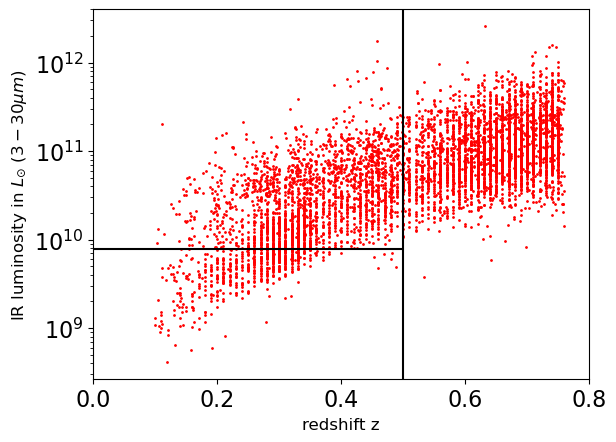

In [68]:
#SKIRTOR
i =IRlumSK_GAMA.loc[IRlumSK_GAMA['redshift'] < 0.5]

low05SK, high05SK = np.percentile(i['IRLum_tot'], [20,100])/L_sol

plt.scatter(IRlumSK_GAMA["redshift"], IRlumSK_GAMA["IRLum_tot"]/L_sol, s=1, c='r', label=r"Scatter of $L_{IR} - z$, GAMA")
# plt.scatter(IRlumSK_COSMOS["redshift"], IRlumSK_COSMOS["IRLum_tot"]/L_sol, s=1, c='b', label=r"Scatter of $L_{IR} - z$, COSMOS")
#plt.colorbar(Lz, label='fAGN')

plt.axvline(0.5, c='black')
plt.hlines(low05SK, colors='black', xmin=0.001, xmax=0.5)

plt.ylabel(r"IR luminosity in $L_{\odot}$ ($3-30 \mu m$)", fontsize=12)
plt.xlabel("redshift z", fontsize = 12)

plt.yscale("log")
plt.xlim(0, 0.8)

# plt.legend(fontsize=8)
# plt.title("SKIRTOR")
plt.show()

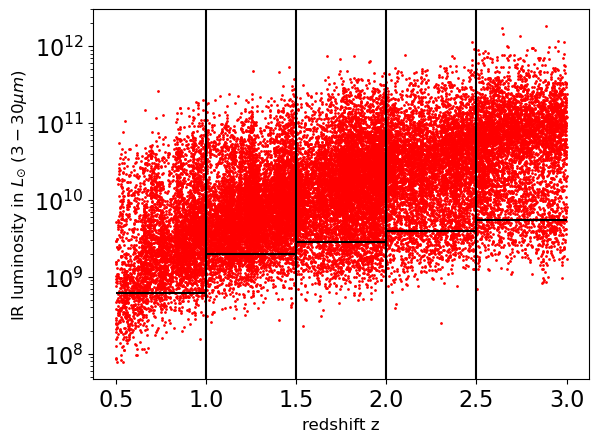

In [70]:
low10SK, high10SK = np.percentile(z_10SK['IRLum_tot'], [10,100])/L_sol

low15SK, high15SK = np.percentile(z_15SK['IRLum_tot'], [10,100])/L_sol

low20SK, high20SK = np.percentile(z_20SK['IRLum_tot'], [10,100])/L_sol

low25SK, high25SK = np.percentile(z_25SK['IRLum_tot'], [10,100])/L_sol

low30SK, high30SK = np.percentile(z_30SK['IRLum_tot'], [10,100])/L_sol


plt.scatter(IRlumSK_COSMOS["redshift"], IRlumSK_COSMOS["IRLum_tot"]/L_sol, s=1, c='r', label=r"Scatter of $L_{IR} - z$, COSMOS")
#plt.colorbar(Lz, label='fAGN')

plt.axvline(1, c='black')
plt.axvline(1.5, c='black')
plt.axvline(2, c='black')
plt.axvline(2.5, c='black')

plt.hlines(low10SK, colors='black', xmin=0.5, xmax=1)
plt.hlines(low15SK, colors='black', xmin=1, xmax=1.5)
plt.hlines(low20SK, colors='black', xmin=1.5, xmax=2)
plt.hlines(low25SK, colors='black', xmin=2, xmax=2.5)
plt.hlines(low30SK, colors='black', xmin=2.5, xmax=3)

plt.ylabel(r"IR luminosity in $L_{\odot}$ ($3-30 \mu m$)", fontsize=12)
plt.xlabel("redshift z", fontsize = 12)


plt.yscale("log")
# plt.legend(fontsize=8)
# plt.title("SKIRTOR")
plt.show()

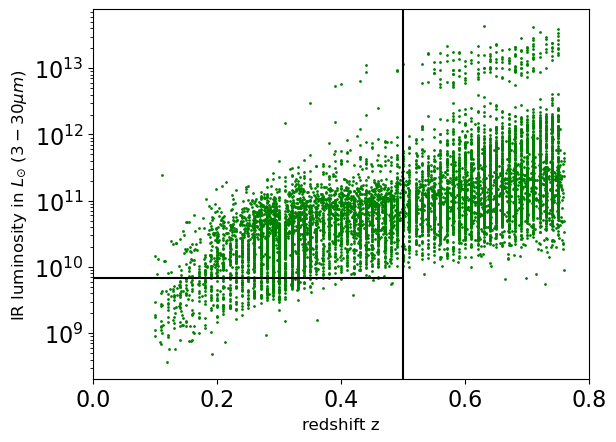

In [71]:
#Fritz
low05F, high05F = np.percentile(IRlumF_GAMA.loc[IRlumF_GAMA['redshift'] < 0.5]['IRLum_tot'], [10,100])/L_sol

plt.scatter(IRlumF_GAMA["redshift"], IRlumF_GAMA["IRLum_tot"]/L_sol, s=1, c='g', label=r"Scatter of $L_{IR} - z$, GAMA")
# plt.scatter(IRlumSK_COSMOS["redshift"], IRlumSK_COSMOS["IRLum_tot"]/L_sol, s=1, c='b', label=r"Scatter of $L_{IR} - z$, COSMOS")
#plt.colorbar(Lz, label='fAGN')

plt.axvline(0.5, c='black')
plt.hlines(low05F, colors='black', xmin=0, xmax=0.5)

plt.ylabel(r"IR luminosity in $L_{\odot}$ ($3-30 \mu m$)", fontsize=12)
plt.xlabel("redshift z", fontsize = 12)

plt.yscale("log")
plt.xlim(0, 0.8)

# plt.legend(fontsize=8)
# plt.title("SKIRTOR")
plt.show()

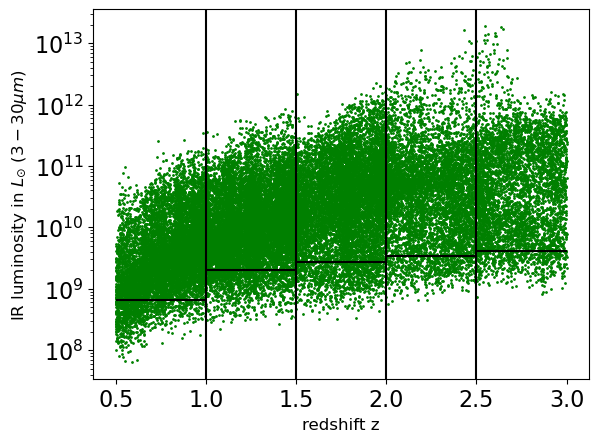

In [72]:
low10F, high10F = np.percentile(z_10F['IRLum_tot'], [10,100])/L_sol

low15F, high15F = np.percentile(z_15F['IRLum_tot'], [10,100])/L_sol

low20F, high20F = np.percentile(z_20F['IRLum_tot'], [10,100])/L_sol

low25F, high25F = np.percentile(z_25F['IRLum_tot'], [10,100])/L_sol

low30F, high30F = np.percentile(z_30F['IRLum_tot'], [10,100])/L_sol


plt.scatter(IRlumF_COSMOS["redshift"], IRlumF_COSMOS["IRLum_tot"]/L_sol, s=1, c='g', label=r"Scatter of $L_{IR} - z$, COSMOS")
#plt.colorbar(Lz, label='fAGN')

plt.axvline(1, c='black')
plt.axvline(1.5, c='black')
plt.axvline(2, c='black')
plt.axvline(2.5, c='black')

plt.hlines(low10F, colors='black', xmin=0.5, xmax=1)
plt.hlines(low15F, colors='black', xmin=1, xmax=1.5)
plt.hlines(low20F, colors='black', xmin=1.5, xmax=2)
plt.hlines(low25F, colors='black', xmin=2, xmax=2.5)
plt.hlines(low30F, colors='black', xmin=2.5, xmax=3)

plt.ylabel(r"IR luminosity in $L_{\odot}$ ($3-30 \mu m$)", fontsize=12)
plt.xlabel("redshift z", fontsize = 12)


plt.yscale("log")
# plt.legend(fontsize=8)
# plt.title("SKIRTOR")
plt.show()

## z_05

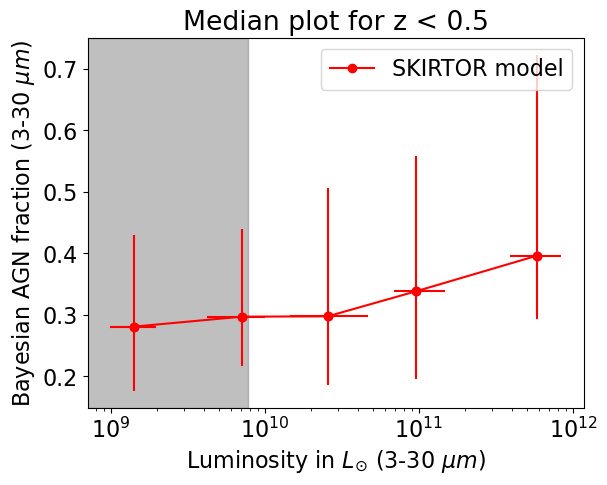

In [15]:
# z < 0.5

# print(f"{max(z_05SK['IRLum_tot']/L_sol):.2e}")
# print(f"{min(z_05SK['IRLum_tot']/L_sol):.2e}")

logIRSK = np.log10(z_05SK['IRLum_tot']/L_sol)
xSK = np.linspace(min(logIRSK), max(logIRSK), 6)

bin_1SK = (z_05SK['IRLum_tot']/L_sol >= 10**xSK[-2])
bin_2SK = (z_05SK['IRLum_tot']/L_sol >= 10**xSK[-3]) & (z_05SK['IRLum_tot']/L_sol < 10**xSK[-2])
bin_3SK = (z_05SK['IRLum_tot']/L_sol >= 10**xSK[-4]) & (z_05SK['IRLum_tot']/L_sol < 10**xSK[-3])
bin_4SK = (z_05SK['IRLum_tot']/L_sol >= 10**xSK[-5]) & (z_05SK['IRLum_tot']/L_sol < 10**xSK[-4])
bin_5SK = (z_05SK['IRLum_tot']/L_sol < 10**xSK[-5])

binSK_list = [bin_1SK, bin_2SK, bin_3SK, bin_4SK, bin_5SK]
binSK_list = binSK_list[::-1]


list_fAGNSK_z05 = np.array([np.median(z_05SK['fAGN_IR'][bin_5SK]), np.median(z_05SK['fAGN_IR'][bin_4SK]), np.median(z_05SK['fAGN_IR'][bin_3SK]), np.median(z_05SK['fAGN_IR'][bin_2SK]), np.median(z_05SK['fAGN_IR'][bin_1SK])])
list_lumSK_z05 = np.array([np.median(z_05SK['IRLum_tot'][bin_5SK]), np.median(z_05SK['IRLum_tot'][bin_4SK]), np.median(z_05SK['IRLum_tot'][bin_3SK]), np.median(z_05SK['IRLum_tot'][bin_2SK]), np.median(z_05SK['IRLum_tot'][bin_1SK])])


lin_05SK = scipy.stats.linregress(np.log10(list_lumSK_z05/L_sol), list_fAGNSK_z05)
lin_05F = scipy.stats.linregress(np.log10(list_lumF_z05/L_sol), list_fAGNF_z05)

xSK_z05 = np.array([np.abs(np.median(z_05SK['IRLum_tot'][i]) - np.percentile(z_05SK['IRLum_tot'][i], [16,84]))/L_sol for i in binSK_list]).T
ySK_z05 = np.array([np.abs(np.median(z_05SK['fAGN_IR'][i]) - np.percentile(z_05SK['fAGN_IR'][i], [16,84])) for i in binSK_list]).T


plt.axvspan(0, low05SK, color='grey', alpha=0.5)

plt.plot(list_lumSK_z05/L_sol, list_fAGNSK_z05, 'ro-', label="SKIRTOR model")
plt.errorbar(list_lumSK_z05/L_sol, 
             list_fAGNSK_z05, 
             xerr= xSK_z05, 
             yerr= ySK_z05, fmt='ro')


plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for z < 0.5")
plt.xscale('log')
plt.legend()
plt.show()

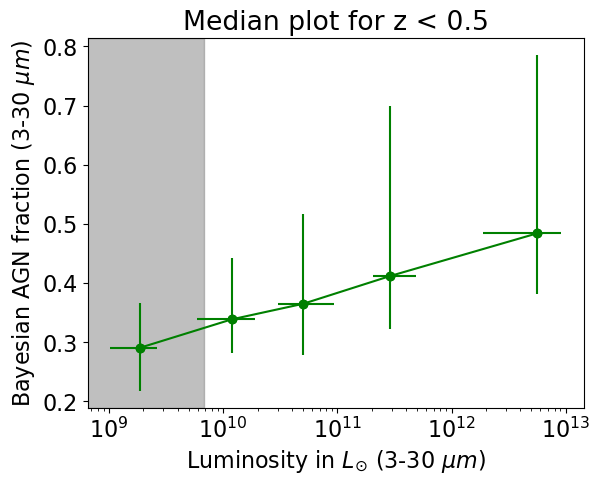

In [14]:
logIRF = np.log10(z_05F['IRLum_tot']/L_sol)
xF = np.linspace(min(logIRF), max(logIRF), 6)

bin_1F = (z_05F['IRLum_tot']/L_sol >= 10**xF[-2])
bin_2F = (z_05F['IRLum_tot']/L_sol >= 10**xF[-3]) & (z_05F['IRLum_tot']/L_sol < 10**xF[-2])
bin_3F = (z_05F['IRLum_tot']/L_sol >= 10**xF[-4]) & (z_05F['IRLum_tot']/L_sol < 10**xF[-3])
bin_4F = (z_05F['IRLum_tot']/L_sol >= 10**xF[-5]) & (z_05F['IRLum_tot']/L_sol < 10**xF[-4])
bin_5F = (z_05F['IRLum_tot']/L_sol < 10**xF[-5])

binF_list = [bin_1F, bin_2F, bin_3F, bin_4F, bin_5F]
binF_list = binF_list[::-1]

list_fAGNF_z05 = np.array([np.median(z_05F['fAGN_IR'][bin_5F]), np.median(z_05F['fAGN_IR'][bin_4F]), np.median(z_05F['fAGN_IR'][bin_3F]), np.median(z_05F['fAGN_IR'][bin_2F]), np.median(z_05F['fAGN_IR'][bin_1F])])
list_lumF_z05 = np.array([np.median(z_05F['IRLum_tot'][bin_5F]), np.median(z_05F['IRLum_tot'][bin_4F]), np.median(z_05F['IRLum_tot'][bin_3F]), np.median(z_05F['IRLum_tot'][bin_2F]), np.median(z_05F['IRLum_tot'][bin_1F])])

xF_z05 = np.array([np.abs(np.median(z_05F['IRLum_tot'][i]) - np.percentile(z_05F['IRLum_tot'][i], [16,84]))/L_sol for i in binF_list]).T
yF_z05 = np.array([np.abs(np.median(z_05F['fAGN_IR'][i]) - np.percentile(z_05F['fAGN_IR'][i], [16,84])) for i in binF_list]).T

plt.axvspan(0, low05F, color='grey', alpha=0.5)

plt.plot(list_lumF_z05/L_sol, list_fAGNF_z05, 'go-', label="Fritz model")
plt.errorbar(list_lumF_z05/L_sol, 
             list_fAGNF_z05, 
             xerr= xF_z05, 
             yerr= yF_z05, fmt='go')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for z < 0.5")
plt.xscale('log')
# plt.legend()
plt.show()

## z_10

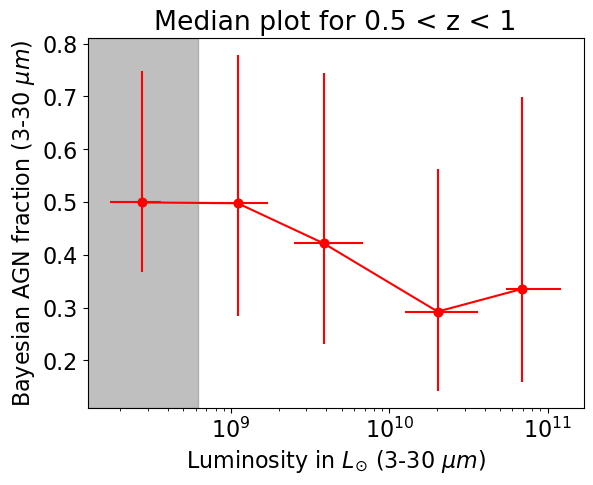

In [21]:
# 0.5 < z < 1

logIRSK = np.log10(z_10SK['IRLum_tot']/L_sol)
xSK = np.linspace(min(logIRSK), max(logIRSK), 6)

bin_1SK = (z_10SK['IRLum_tot']/L_sol >= 10**xSK[-2])
bin_2SK = (z_10SK['IRLum_tot']/L_sol >= 10**xSK[-3]) & (z_10SK['IRLum_tot']/L_sol < 10**xSK[-2])
bin_3SK = (z_10SK['IRLum_tot']/L_sol >= 10**xSK[-4]) & (z_10SK['IRLum_tot']/L_sol < 10**xSK[-3])
bin_4SK = (z_10SK['IRLum_tot']/L_sol >= 10**xSK[-5]) & (z_10SK['IRLum_tot']/L_sol < 10**xSK[-4])
bin_5SK = (z_10SK['IRLum_tot']/L_sol < 10**xSK[-5])

binSK_list = [bin_1SK, bin_2SK, bin_3SK, bin_4SK, bin_5SK]
binSK_list = binSK_list[::-1]


list_fAGNSK_z10 = np.array([np.median(z_10SK['fAGN_IR'][bin_5SK]), np.median(z_10SK['fAGN_IR'][bin_4SK]), np.median(z_10SK['fAGN_IR'][bin_3SK]), np.median(z_10SK['fAGN_IR'][bin_2SK]), np.median(z_10SK['fAGN_IR'][bin_1SK])])
list_lumSK_z10 = np.array([np.median(z_10SK['IRLum_tot'][bin_5SK]), np.median(z_10SK['IRLum_tot'][bin_4SK]), np.median(z_10SK['IRLum_tot'][bin_3SK]), np.median(z_10SK['IRLum_tot'][bin_2SK]), np.median(z_10SK['IRLum_tot'][bin_1SK])])


lin_10SK = scipy.stats.linregress(np.log10(list_lumSK_z10/L_sol), list_fAGNSK_z10)

xSK_z10 = np.array([np.abs(np.median(z_10SK['IRLum_tot'][i]) - np.percentile(z_10SK['IRLum_tot'][i], [16,84]))/L_sol for i in binSK_list]).T
ySK_z10 = np.array([np.abs(np.median(z_10SK['fAGN_IR'][i]) - np.percentile(z_10SK['fAGN_IR'][i], [16,84])) for i in binSK_list]).T

plt.axvspan(0, low10SK, color='grey', alpha=0.5)

plt.plot(list_lumSK_z10/L_sol, list_fAGNSK_z10, 'ro-', label="SKIRTOR model")
plt.errorbar(list_lumSK_z10/L_sol, 
             list_fAGNSK_z10, 
             xerr= xSK_z10, 
             yerr= ySK_z10, fmt='ro')


plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 0.5 < z < 1")
plt.xscale('log')
# plt.legend()
plt.show()

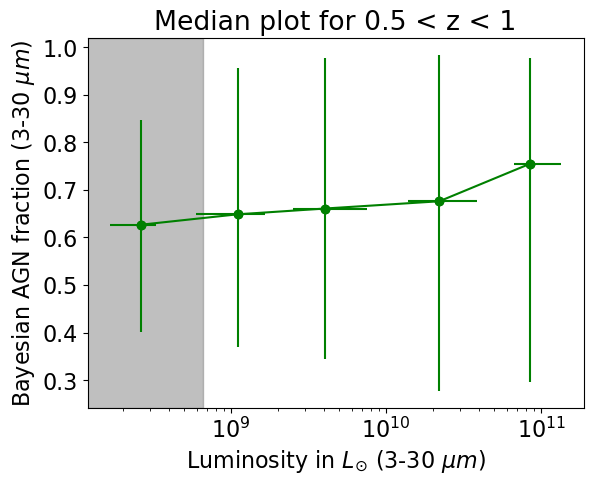

In [22]:
logIRF = np.log10(z_10F['IRLum_tot']/L_sol)
xF = np.linspace(min(logIRF), max(logIRF), 6)
#print(xF)

bin_1F = (z_10F['IRLum_tot']/L_sol >= 10**xF[-2])
bin_2F = (z_10F['IRLum_tot']/L_sol >= 10**xF[-3]) & (z_10F['IRLum_tot']/L_sol < 10**xF[-2])
bin_3F = (z_10F['IRLum_tot']/L_sol >= 10**xF[-4]) & (z_10F['IRLum_tot']/L_sol < 10**xF[-3])
bin_4F = (z_10F['IRLum_tot']/L_sol >= 10**xF[-5]) & (z_10F['IRLum_tot']/L_sol < 10**xF[-4])
bin_5F = (z_10F['IRLum_tot']/L_sol < 10**xF[-5])

binF_list = [bin_1F, bin_2F, bin_3F, bin_4F, bin_5F]
binF_list = binF_list[::-1]

list_fAGNF_z10 = np.array([np.median(z_10F['fAGN_IR'][bin_5F]), np.median(z_10F['fAGN_IR'][bin_4F]), np.median(z_10F['fAGN_IR'][bin_3F]), np.median(z_10F['fAGN_IR'][bin_2F]), np.median(z_10F['fAGN_IR'][bin_1F])])
list_lumF_z10 = np.array([np.median(z_10F['IRLum_tot'][bin_5F]), np.median(z_10F['IRLum_tot'][bin_4F]), np.median(z_10F['IRLum_tot'][bin_3F]), np.median(z_10F['IRLum_tot'][bin_2F]), np.median(z_10F['IRLum_tot'][bin_1F])])

lin_10F = scipy.stats.linregress(np.log10(list_lumF_z10/L_sol), list_fAGNF_z10)

xF_z10 = np.array([np.abs(np.median(z_10F['IRLum_tot'][i]) - np.percentile(z_10F['IRLum_tot'][i], [16,84]))/L_sol for i in binF_list]).T
yF_z10 = np.array([np.abs(np.median(z_10F['fAGN_IR'][i]) - np.percentile(z_10F['fAGN_IR'][i], [16,84])) for i in binF_list]).T

plt.axvspan(0, low10F, color='grey', alpha=0.5)

plt.plot(list_lumF_z10/L_sol, list_fAGNF_z10, 'go-', label="Fritz model")
plt.errorbar(list_lumF_z10/L_sol, 
             list_fAGNF_z10, 
             xerr= xF_z10, 
             yerr= yF_z10, fmt='go')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 0.5 < z < 1")
plt.xscale('log')
# plt.legend()
plt.show()

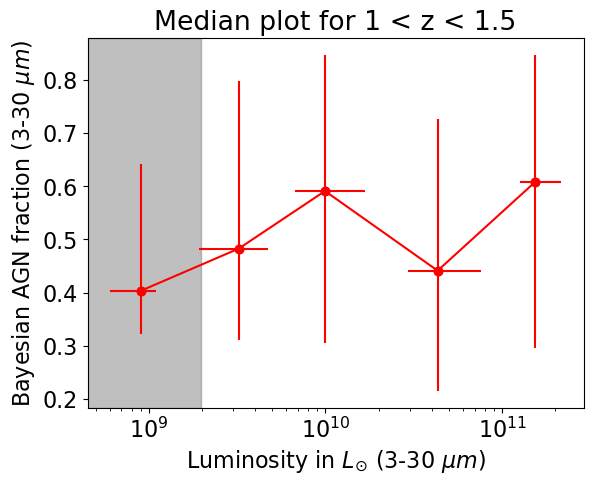

In [25]:
# 1 < z < 1.5

logIRSK = np.log10(z_15SK['IRLum_tot']/L_sol)
xSK = np.linspace(min(logIRSK), max(logIRSK), 6)

bin_1SK = (z_15SK['IRLum_tot']/L_sol >= 10**xSK[-2])
bin_2SK = (z_15SK['IRLum_tot']/L_sol >= 10**xSK[-3]) & (z_15SK['IRLum_tot']/L_sol < 10**xSK[-2])
bin_3SK = (z_15SK['IRLum_tot']/L_sol >= 10**xSK[-4]) & (z_15SK['IRLum_tot']/L_sol < 10**xSK[-3])
bin_4SK = (z_15SK['IRLum_tot']/L_sol >= 10**xSK[-5]) & (z_15SK['IRLum_tot']/L_sol < 10**xSK[-4])
bin_5SK = (z_15SK['IRLum_tot']/L_sol < 10**xSK[-5])

binSK_list = [bin_1SK, bin_2SK, bin_3SK, bin_4SK, bin_5SK]
binSK_list = binSK_list[::-1]

list_fAGNSK_z15 = np.array([np.median(z_15SK['fAGN_IR'][bin_5SK]), np.median(z_15SK['fAGN_IR'][bin_4SK]), np.median(z_15SK['fAGN_IR'][bin_3SK]), np.median(z_15SK['fAGN_IR'][bin_2SK]), np.median(z_15SK['fAGN_IR'][bin_1SK])])
list_lumSK_z15 = np.array([np.median(z_15SK['IRLum_tot'][bin_5SK]), np.median(z_15SK['IRLum_tot'][bin_4SK]), np.median(z_15SK['IRLum_tot'][bin_3SK]), np.median(z_15SK['IRLum_tot'][bin_2SK]), np.median(z_15SK['IRLum_tot'][bin_1SK])])


lin_15SK = scipy.stats.linregress(np.log10(list_lumSK_z15/L_sol), list_fAGNSK_z15)

xSK_z15 = np.array([np.abs(np.median(z_15SK['IRLum_tot'][i]) - np.percentile(z_15SK['IRLum_tot'][i], [16,84]))/L_sol for i in binSK_list]).T
ySK_z15 = np.array([np.abs(np.median(z_15SK['fAGN_IR'][i]) - np.percentile(z_15SK['fAGN_IR'][i], [16,84])) for i in binSK_list]).T

plt.axvspan(0, low15SK, color='grey', alpha=0.5)

plt.plot(list_lumSK_z15/L_sol, list_fAGNSK_z15, 'ro-', label="SKIRTOR model")
plt.errorbar(list_lumSK_z15/L_sol, 
             list_fAGNSK_z15, 
             xerr= xSK_z15, 
             yerr= ySK_z15, fmt='ro')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 1 < z < 1.5")
plt.xscale('log')
# plt.legend()
plt.show()

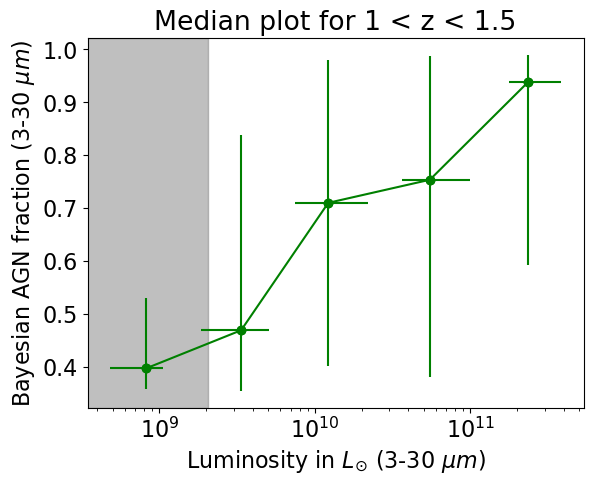

In [24]:
logIRF = np.log10(z_15F['IRLum_tot']/L_sol)
xF = np.linspace(min(logIRF), max(logIRF), 6)

bin_1F = (z_15F['IRLum_tot']/L_sol >= 10**xF[-2])
bin_2F = (z_15F['IRLum_tot']/L_sol >= 10**xF[-3]) & (z_15F['IRLum_tot']/L_sol < 10**xF[-2])
bin_3F = (z_15F['IRLum_tot']/L_sol >= 10**xF[-4]) & (z_15F['IRLum_tot']/L_sol < 10**xF[-3])
bin_4F = (z_15F['IRLum_tot']/L_sol >= 10**xF[-5]) & (z_15F['IRLum_tot']/L_sol < 10**xF[-4])
bin_5F = (z_15F['IRLum_tot']/L_sol < 10**xF[-5])

binF_list = [bin_1F, bin_2F, bin_3F, bin_4F, bin_5F]
binF_list = binF_list[::-1]

list_fAGNF_z15 = np.array([np.median(z_15F['fAGN_IR'][bin_5F]), np.median(z_15F['fAGN_IR'][bin_4F]), np.median(z_15F['fAGN_IR'][bin_3F]), np.median(z_15F['fAGN_IR'][bin_2F]), np.median(z_15F['fAGN_IR'][bin_1F])])
list_lumF_z15 = np.array([np.median(z_15F['IRLum_tot'][bin_5F]), np.median(z_15F['IRLum_tot'][bin_4F]), np.median(z_15F['IRLum_tot'][bin_3F]), np.median(z_15F['IRLum_tot'][bin_2F]), np.median(z_15F['IRLum_tot'][bin_1F])])

lin_15F = scipy.stats.linregress(np.log10(list_lumF_z15/L_sol), list_fAGNF_z15)

xF_z15 = np.array([np.abs(np.median(z_15F['IRLum_tot'][i]) - np.percentile(z_15F['IRLum_tot'][i], [16,84]))/L_sol for i in binF_list]).T
yF_z15 = np.array([np.abs(np.median(z_15F['fAGN_IR'][i]) - np.percentile(z_15F['fAGN_IR'][i], [16,84])) for i in binF_list]).T

plt.axvspan(0, low15F, color='grey', alpha=0.5)

plt.plot(list_lumF_z15/L_sol, list_fAGNF_z15, 'go-', label="Fritz model")
plt.errorbar(list_lumF_z15/L_sol, 
             list_fAGNF_z15, 
             xerr= xF_z15, 
             yerr= yF_z15, fmt='go')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 1 < z < 1.5")
plt.xscale('log')
# plt.legend()
plt.show()

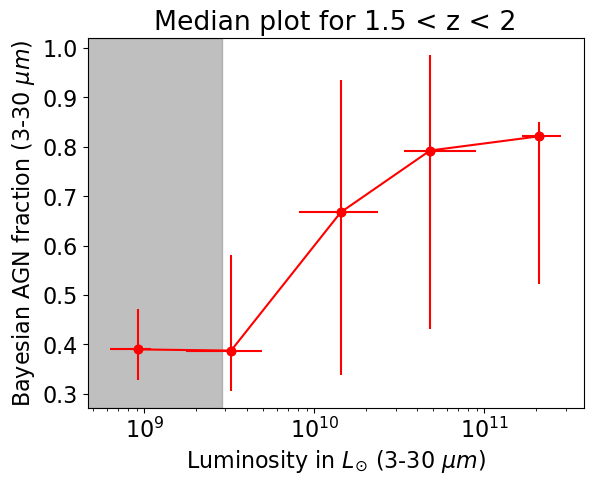

In [29]:
# 1.5 < z < 2

logIRSK = np.log10(z_20SK['IRLum_tot']/L_sol)
xSK = np.linspace(min(logIRSK), max(logIRSK), 6)

bin_1SK = (z_20SK['IRLum_tot']/L_sol >= 10**xSK[-2])
bin_2SK = (z_20SK['IRLum_tot']/L_sol >= 10**xSK[-3]) & (z_20SK['IRLum_tot']/L_sol < 10**xSK[-2])
bin_3SK = (z_20SK['IRLum_tot']/L_sol >= 10**xSK[-4]) & (z_20SK['IRLum_tot']/L_sol < 10**xSK[-3])
bin_4SK = (z_20SK['IRLum_tot']/L_sol >= 10**xSK[-5]) & (z_20SK['IRLum_tot']/L_sol < 10**xSK[-4])
bin_5SK = (z_20SK['IRLum_tot']/L_sol < 10**xSK[-5])

binSK_list = [bin_1SK, bin_2SK, bin_3SK, bin_4SK, bin_5SK]
binSK_list = binSK_list[::-1]

list_fAGNSK_z20 = np.array([np.median(z_20SK['fAGN_IR'][bin_5SK]), np.median(z_20SK['fAGN_IR'][bin_4SK]), np.median(z_20SK['fAGN_IR'][bin_3SK]), np.median(z_20SK['fAGN_IR'][bin_2SK]), np.median(z_20SK['fAGN_IR'][bin_1SK])])
list_lumSK_z20 = np.array([np.median(z_20SK['IRLum_tot'][bin_5SK]), np.median(z_20SK['IRLum_tot'][bin_4SK]), np.median(z_20SK['IRLum_tot'][bin_3SK]), np.median(z_20SK['IRLum_tot'][bin_2SK]), np.median(z_20SK['IRLum_tot'][bin_1SK])])

lin_20SK = scipy.stats.linregress(np.log10(list_lumSK_z20/L_sol), list_fAGNSK_z20)

xSK_z20 = np.array([np.abs(np.median(z_20SK['IRLum_tot'][i]) - np.percentile(z_20SK['IRLum_tot'][i], [16,84]))/L_sol for i in binSK_list]).T
ySK_z20 = np.array([np.abs(np.median(z_20SK['fAGN_IR'][i]) - np.percentile(z_20SK['fAGN_IR'][i], [16,84])) for i in binSK_list]).T

plt.axvspan(0, low20SK, color='grey', alpha=0.5)

plt.plot(list_lumSK_z20/L_sol, list_fAGNSK_z20, 'ro-', label="SKIRTOR model")
plt.errorbar(list_lumSK_z20/L_sol, 
             list_fAGNSK_z20, 
             xerr= xSK_z20, 
             yerr= ySK_z20, fmt='ro')


plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 1.5 < z < 2")
plt.xscale('log')
# plt.legend()
plt.show()

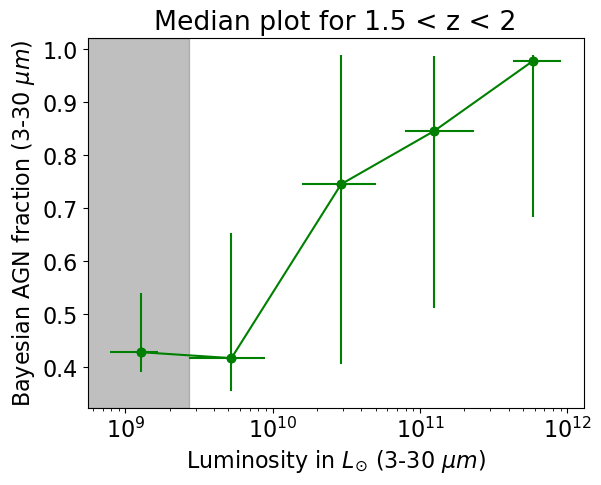

In [30]:
logIRF = np.log10(z_20F['IRLum_tot']/L_sol)
xF = np.linspace(min(logIRF), max(logIRF), 6)
#print(xF)

bin_1F = (z_20F['IRLum_tot']/L_sol >= 10**xF[-2])
bin_2F = (z_20F['IRLum_tot']/L_sol >= 10**xF[-3]) & (z_20F['IRLum_tot']/L_sol < 10**xF[-2])
bin_3F = (z_20F['IRLum_tot']/L_sol >= 10**xF[-4]) & (z_20F['IRLum_tot']/L_sol < 10**xF[-3])
bin_4F = (z_20F['IRLum_tot']/L_sol >= 10**xF[-5]) & (z_20F['IRLum_tot']/L_sol < 10**xF[-4])
bin_5F = (z_20F['IRLum_tot']/L_sol < 10**xF[-5])

binF_list = [bin_1F, bin_2F, bin_3F, bin_4F, bin_5F]
binF_list = binF_list[::-1]

list_fAGNF_z20 = np.array([np.median(z_20F['fAGN_IR'][bin_5F]), np.median(z_20F['fAGN_IR'][bin_4F]), np.median(z_20F['fAGN_IR'][bin_3F]), np.median(z_20F['fAGN_IR'][bin_2F]), np.median(z_20F['fAGN_IR'][bin_1F])])
list_lumF_z20 = np.array([np.median(z_20F['IRLum_tot'][bin_5F]), np.median(z_20F['IRLum_tot'][bin_4F]), np.median(z_20F['IRLum_tot'][bin_3F]), np.median(z_20F['IRLum_tot'][bin_2F]), np.median(z_20F['IRLum_tot'][bin_1F])])

lin_20F = scipy.stats.linregress(np.log10(list_lumF_z20/L_sol), list_fAGNF_z20)

xF_z20 = np.array([np.abs(np.median(z_20F['IRLum_tot'][i]) - np.percentile(z_20F['IRLum_tot'][i], [16,84]))/L_sol for i in binF_list]).T
yF_z20 = np.array([np.abs(np.median(z_20F['fAGN_IR'][i]) - np.percentile(z_20F['fAGN_IR'][i], [16,84])) for i in binF_list]).T

plt.axvspan(0, low20F, color='grey', alpha=0.5)

plt.plot(list_lumF_z20/L_sol, list_fAGNF_z20, 'go-', label="Fritz model")
plt.errorbar(list_lumF_z20/L_sol, 
             list_fAGNF_z20, 
             xerr= xF_z20, 
             yerr= yF_z20, fmt='go')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 1.5 < z < 2")
plt.xscale('log')
# plt.legend()
plt.show()

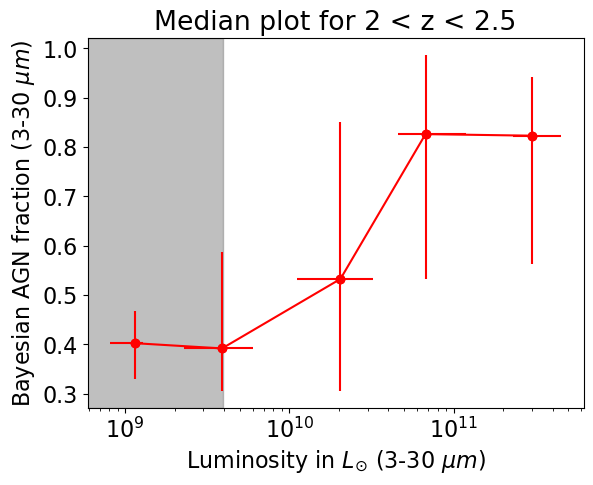

In [49]:
# 2 < z < 2.5

logIRSK = np.log10(z_25SK['IRLum_tot']/L_sol)
xSK = np.linspace(min(logIRSK), max(logIRSK), 6)

bin_1SK = (z_25SK['IRLum_tot']/L_sol >= 10**xSK[-2])
bin_2SK = (z_25SK['IRLum_tot']/L_sol >= 10**xSK[-3]) & (z_25SK['IRLum_tot']/L_sol < 10**xSK[-2])
bin_3SK = (z_25SK['IRLum_tot']/L_sol >= 10**xSK[-4]) & (z_25SK['IRLum_tot']/L_sol < 10**xSK[-3])
bin_4SK = (z_25SK['IRLum_tot']/L_sol >= 10**xSK[-5]) & (z_25SK['IRLum_tot']/L_sol < 10**xSK[-4])
bin_5SK = (z_25SK['IRLum_tot']/L_sol < 10**xSK[-5])

binSK_list = [bin_1SK, bin_2SK, bin_3SK, bin_4SK, bin_5SK]
binSK_list = binSK_list[::-1]

list_fAGNSK_z25 = np.array([np.median(z_25SK['fAGN_IR'][bin_5SK]), np.median(z_25SK['fAGN_IR'][bin_4SK]), np.median(z_25SK['fAGN_IR'][bin_3SK]), np.median(z_25SK['fAGN_IR'][bin_2SK]), np.median(z_25SK['fAGN_IR'][bin_1SK])])
list_lumSK_z25 = np.array([np.median(z_25SK['IRLum_tot'][bin_5SK]), np.median(z_25SK['IRLum_tot'][bin_4SK]), np.median(z_25SK['IRLum_tot'][bin_3SK]), np.median(z_25SK['IRLum_tot'][bin_2SK]), np.median(z_25SK['IRLum_tot'][bin_1SK])])

lin_25SK = scipy.stats.linregress(np.log10(list_lumSK_z25/L_sol), list_fAGNSK_z25)

xSK_z25 = np.array([np.abs(np.median(z_25SK['IRLum_tot'][i]) - np.percentile(z_25SK['IRLum_tot'][i], [16,84]))/L_sol for i in binSK_list]).T
ySK_z25 = np.array([np.abs(np.median(z_25SK['fAGN_IR'][i]) - np.percentile(z_25SK['fAGN_IR'][i], [16,84])) for i in binSK_list]).T

plt.axvspan(0, low25SK, color='grey', alpha=0.5)

plt.plot(list_lumSK_z25/L_sol, list_fAGNSK_z25, 'ro-', label="SKIRTOR model")
plt.errorbar(list_lumSK_z25/L_sol, 
             list_fAGNSK_z25, 
             xerr= xSK_z25, 
             yerr= ySK_z25, fmt='ro')


plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 2 < z < 2.5")
plt.xscale('log')
# plt.legend()
plt.show()

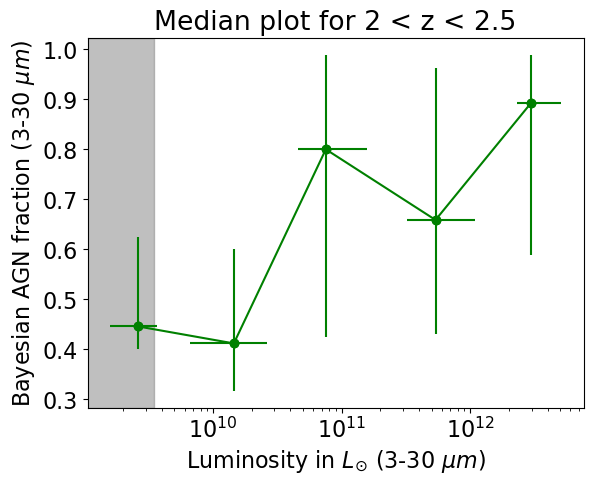

In [55]:
logIRF = np.log10(z_25F['IRLum_tot']/L_sol)
xF = np.linspace(min(logIRF), max(logIRF), 6)

bin_1F = (z_25F['IRLum_tot']/L_sol >= 10**xF[-2])
bin_2F = (z_25F['IRLum_tot']/L_sol >= 10**xF[-3]) & (z_25F['IRLum_tot']/L_sol < 10**xF[-2])
bin_3F = (z_25F['IRLum_tot']/L_sol >= 10**xF[-4]) & (z_25F['IRLum_tot']/L_sol < 10**xF[-3])
bin_4F = (z_25F['IRLum_tot']/L_sol >= 10**xF[-5]) & (z_25F['IRLum_tot']/L_sol < 10**xF[-4])
bin_5F = (z_25F['IRLum_tot']/L_sol < 10**xF[-5])

binF_list = [bin_1F, bin_2F, bin_3F, bin_4F, bin_5F]
binF_list = binF_list[::-1]

list_fAGNF_z25 = np.array([np.median(z_25F['fAGN_IR'][bin_5F]), np.median(z_25F['fAGN_IR'][bin_4F]), np.median(z_25F['fAGN_IR'][bin_3F]), np.median(z_25F['fAGN_IR'][bin_2F]), np.median(z_25F['fAGN_IR'][bin_1F])])
list_lumF_z25 = np.array([np.median(z_25F['IRLum_tot'][bin_5F]), np.median(z_25F['IRLum_tot'][bin_4F]), np.median(z_25F['IRLum_tot'][bin_3F]), np.median(z_25F['IRLum_tot'][bin_2F]), np.median(z_25F['IRLum_tot'][bin_1F])])

lin_25F = scipy.stats.linregress(np.log10(list_lumF_z25/L_sol), list_fAGNF_z25)

xF_z25 = np.array([np.abs(np.median(z_25F['IRLum_tot'][i]) - np.percentile(z_25F['IRLum_tot'][i], [16,84]))/L_sol for i in binF_list]).T
yF_z25 = np.array([np.abs(np.median(z_25F['fAGN_IR'][i]) - np.percentile(z_25F['fAGN_IR'][i], [16,84])) for i in binF_list]).T

plt.axvspan(0, low25F, color='grey', alpha=0.5)

plt.plot(list_lumF_z25/L_sol, list_fAGNF_z25, 'go-', label="Fritz model")
plt.errorbar(list_lumF_z25/L_sol, 
             list_fAGNF_z25, 
             xerr= xF_z25, 
             yerr= yF_z25, fmt='go')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 2 < z < 2.5")
plt.xscale('log')
# plt.legend()
plt.show()

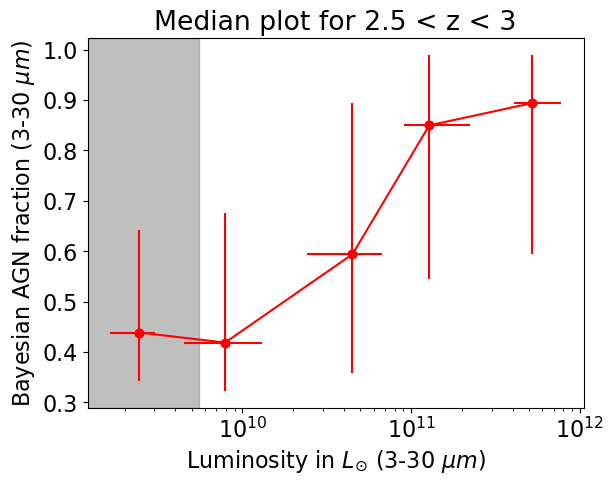

In [56]:
# 2.5 < z < 3

logIRSK = np.log10(z_30SK['IRLum_tot']/L_sol)
xSK = np.linspace(min(logIRSK), max(logIRSK), 6)

bin_1SK = (z_30SK['IRLum_tot']/L_sol >= 10**xSK[-2])
bin_2SK = (z_30SK['IRLum_tot']/L_sol >= 10**xSK[-3]) & (z_30SK['IRLum_tot']/L_sol < 10**xSK[-2])
bin_3SK = (z_30SK['IRLum_tot']/L_sol >= 10**xSK[-4]) & (z_30SK['IRLum_tot']/L_sol < 10**xSK[-3])
bin_4SK = (z_30SK['IRLum_tot']/L_sol >= 10**xSK[-5]) & (z_30SK['IRLum_tot']/L_sol < 10**xSK[-4])
bin_5SK = (z_30SK['IRLum_tot']/L_sol < 10**xSK[-5])



binSK_list = [bin_1SK, bin_2SK, bin_3SK, bin_4SK, bin_5SK]
binSK_list = binSK_list[::-1]



list_fAGNSK_z30 = np.array([np.median(z_30SK['fAGN_IR'][bin_5SK]), np.median(z_30SK['fAGN_IR'][bin_4SK]), np.median(z_30SK['fAGN_IR'][bin_3SK]), np.median(z_30SK['fAGN_IR'][bin_2SK]), np.median(z_30SK['fAGN_IR'][bin_1SK])])
list_lumSK_z30 = np.array([np.median(z_30SK['IRLum_tot'][bin_5SK]), np.median(z_30SK['IRLum_tot'][bin_4SK]), np.median(z_30SK['IRLum_tot'][bin_3SK]), np.median(z_30SK['IRLum_tot'][bin_2SK]), np.median(z_30SK['IRLum_tot'][bin_1SK])])


lin_30SK = scipy.stats.linregress(np.log10(list_lumSK_z30/L_sol), list_fAGNSK_z30)

xSK_z30 = np.array([np.abs(np.median(z_30SK['IRLum_tot'][i]) - np.percentile(z_30SK['IRLum_tot'][i], [16,84]))/L_sol for i in binSK_list]).T
ySK_z30 = np.array([np.abs(np.median(z_30SK['fAGN_IR'][i]) - np.percentile(z_30SK['fAGN_IR'][i], [16,84])) for i in binSK_list]).T

plt.axvspan(0, low30SK, color='grey', alpha=0.5)

plt.plot(list_lumSK_z30/L_sol, list_fAGNSK_z30, 'ro-', label="SKIRTOR model")
plt.errorbar(list_lumSK_z30/L_sol, 
             list_fAGNSK_z30, 
             xerr= xSK_z30, 
             yerr= ySK_z30, fmt='ro')



plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 2.5 < z < 3")
plt.xscale('log')
# plt.legend()
plt.show()

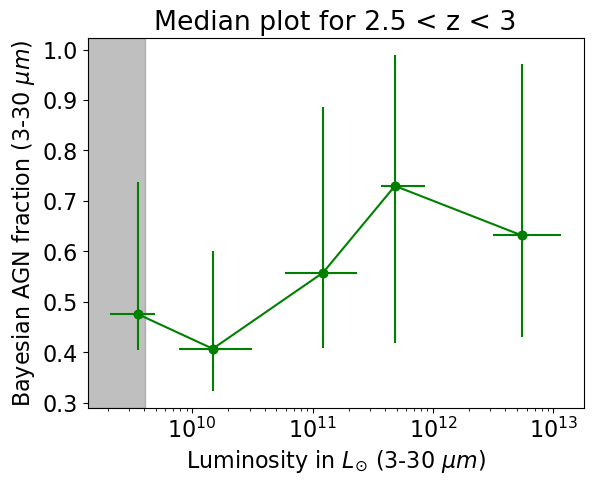

In [57]:
logIRF = np.log10(z_30F['IRLum_tot']/L_sol)
xF = np.linspace(min(logIRF), max(logIRF), 6)
#print(xF)

bin_1F = (z_30F['IRLum_tot']/L_sol >= 10**xF[-2])
bin_2F = (z_30F['IRLum_tot']/L_sol >= 10**xF[-3]) & (z_30F['IRLum_tot']/L_sol < 10**xF[-2])
bin_3F = (z_30F['IRLum_tot']/L_sol >= 10**xF[-4]) & (z_30F['IRLum_tot']/L_sol < 10**xF[-3])
bin_4F = (z_30F['IRLum_tot']/L_sol >= 10**xF[-5]) & (z_30F['IRLum_tot']/L_sol < 10**xF[-4])
bin_5F = (z_30F['IRLum_tot']/L_sol < 10**xF[-5])
binF_list = [bin_1F, bin_2F, bin_3F, bin_4F, bin_5F]
binF_list = binF_list[::-1]
list_fAGNF_z30 = np.array([np.median(z_30F['fAGN_IR'][bin_5F]), np.median(z_30F['fAGN_IR'][bin_4F]), np.median(z_30F['fAGN_IR'][bin_3F]), np.median(z_30F['fAGN_IR'][bin_2F]), np.median(z_30F['fAGN_IR'][bin_1F])])
list_lumF_z30 = np.array([np.median(z_30F['IRLum_tot'][bin_5F]), np.median(z_30F['IRLum_tot'][bin_4F]), np.median(z_30F['IRLum_tot'][bin_3F]), np.median(z_30F['IRLum_tot'][bin_2F]), np.median(z_30F['IRLum_tot'][bin_1F])])

lin_30F = scipy.stats.linregress(np.log10(list_lumF_z30/L_sol), list_fAGNF_z30)

xF_z30 = np.array([np.abs(np.median(z_30F['IRLum_tot'][i]) - np.percentile(z_30F['IRLum_tot'][i], [16,84]))/L_sol for i in binF_list]).T
yF_z30 = np.array([np.abs(np.median(z_30F['fAGN_IR'][i]) - np.percentile(z_30F['fAGN_IR'][i], [16,84])) for i in binF_list]).T

plt.axvspan(0, low30F, color='grey', alpha=0.5)

plt.plot(list_lumF_z30/L_sol, list_fAGNF_z30, 'go-', label="Fritz model")
plt.errorbar(list_lumF_z30/L_sol, 
             list_fAGNF_z30, 
             xerr= xF_z30, 
             yerr= yF_z30, fmt='go')

plt.ylabel("Bayesian AGN fraction (3-30 $\mu m$)")
plt.xlabel("Luminosity in $L_{\odot}$ (3-30 $\mu m$)")
plt.title("Median plot for 2.5 < z < 3")
plt.xscale('log')
# plt.legend()
plt.show()

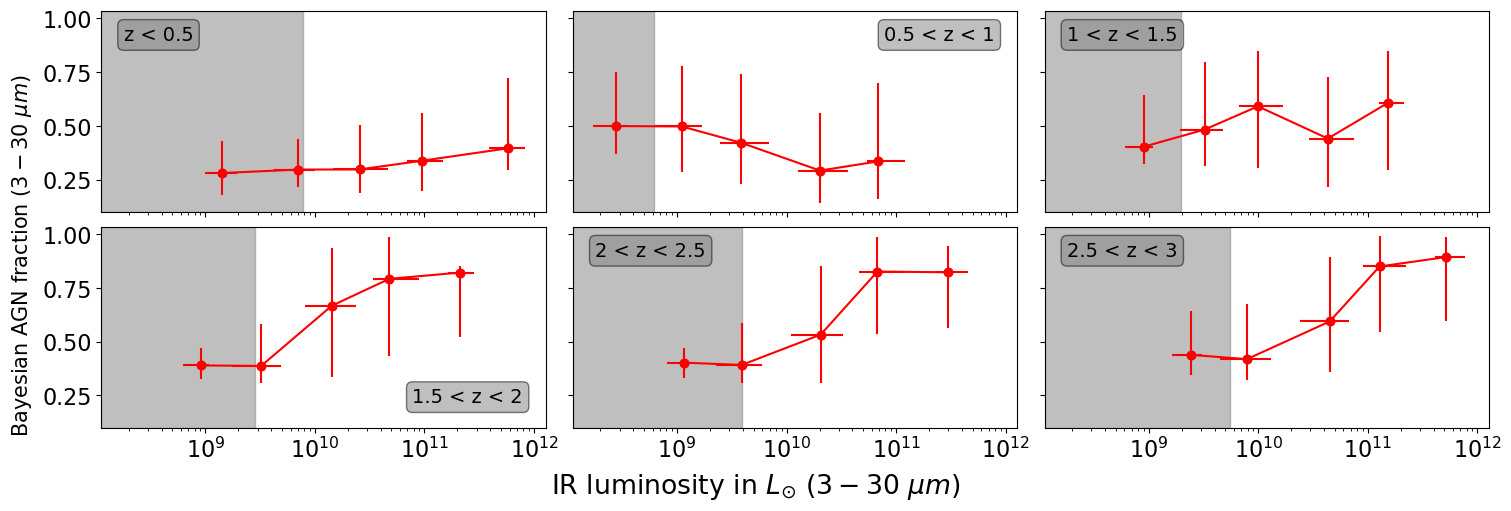

In [58]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=True, layout='constrained')

ax1.axvspan(0, low05SK, color='grey', alpha=0.5)

ax1.plot(list_lumSK_z05/L_sol, list_fAGNSK_z05, 'ro-', label="SKIRTOR model")
ax1.errorbar(list_lumSK_z05/L_sol, 
             list_fAGNSK_z05, 
             xerr= xSK_z05, 
             yerr= ySK_z05, fmt='ro')

ax2.axvspan(0, low10SK, color='grey', alpha=0.5)

ax2.plot(list_lumSK_z10/L_sol, list_fAGNSK_z10, 'ro-', label="SKIRTOR model")
ax2.errorbar(list_lumSK_z10/L_sol, 
             list_fAGNSK_z10, 
             xerr= xSK_z10, 
             yerr= ySK_z10, fmt='ro')

ax3.axvspan(0, low15SK, color='grey', alpha=0.5)

ax3.plot(list_lumSK_z15/L_sol, list_fAGNSK_z15, 'ro-', label="SKIRTOR model")
ax3.errorbar(list_lumSK_z15/L_sol, 
             list_fAGNSK_z15, 
             xerr= xSK_z15, 
             yerr= ySK_z15, fmt='ro')

ax4.axvspan(0, low20SK, color='grey', alpha=0.5)

ax4.plot(list_lumSK_z20/L_sol, list_fAGNSK_z20, 'ro-', label="SKIRTOR model")
ax4.errorbar(list_lumSK_z20/L_sol, 
             list_fAGNSK_z20, 
             xerr= xSK_z20, 
             yerr= ySK_z20, fmt='ro')

ax5.axvspan(0, low25SK, color='grey', alpha=0.5)

ax5.plot(list_lumSK_z25/L_sol, list_fAGNSK_z25, 'ro-', label="SKIRTOR model")
ax5.errorbar(list_lumSK_z25/L_sol, 
             list_fAGNSK_z25, 
             xerr= xSK_z25, 
             yerr= ySK_z25, fmt='ro')

ax6.axvspan(0, low30SK, color='grey', alpha=0.5)

ax6.plot(list_lumSK_z30/L_sol, list_fAGNSK_z30, 'ro-', label="SKIRTOR model")
ax6.errorbar(list_lumSK_z30/L_sol, 
             list_fAGNSK_z30, 
             xerr= xSK_z30, 
             yerr= ySK_z30, fmt='ro')


ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")
ax4.set_xscale("log")
ax5.set_xscale("log")
ax6.set_xscale("log")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax1.text(0.05, 0.93, 'z < 0.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax2.text(0.70, 0.93, '0.5 < z < 1', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax3.text(0.05, 0.93, '1 < z < 1.5', transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax4.text(0.70, 0.20, '1.5 < z < 2', transform=ax4.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax5.text(0.05, 0.93, '2 < z < 2.5', transform=ax5.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax6.text(0.05, 0.93, '2.5 < z < 3', transform=ax6.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

# fig.suptitle("Fritz model plots (3-30 $\mu m$)")
fig.supxlabel('IR luminosity in $L_{\odot}$ ($3-30\ \mu m$)')
fig.supylabel('Bayesian AGN fraction ($3-30\ \mu m$)', fontsize=15)

plt.show()

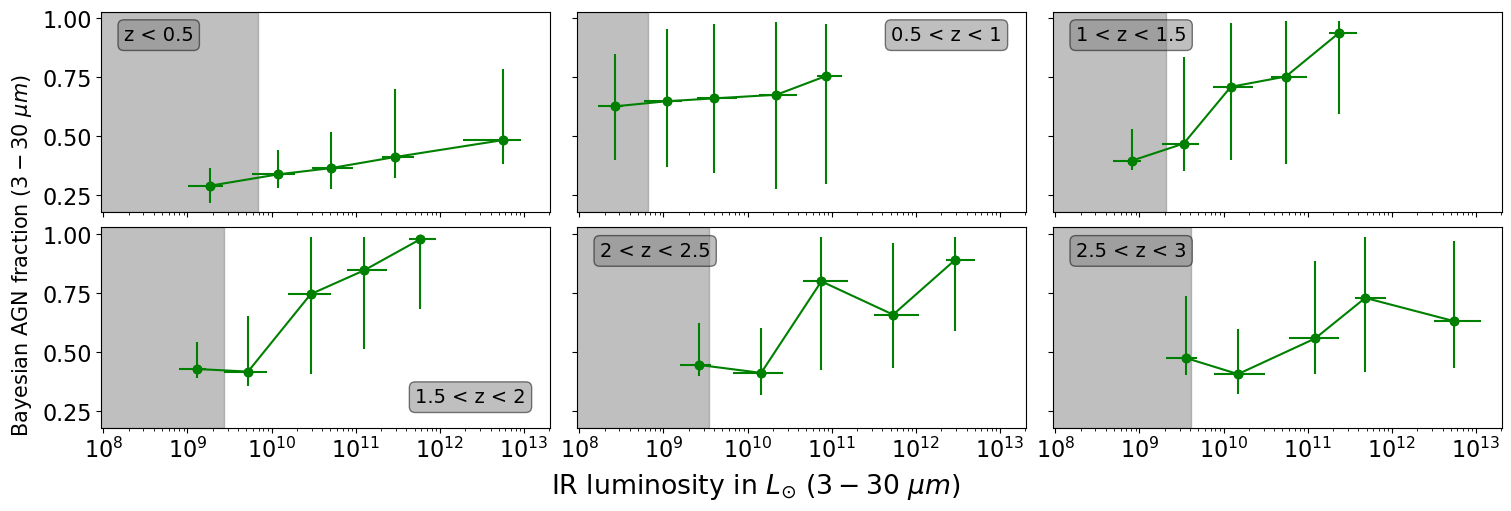

In [59]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=True, layout='constrained')

ax1.axvspan(0, low05F, color='grey', alpha=0.5)

ax1.plot(list_lumF_z05/L_sol, list_fAGNF_z05, 'go-', label="SKIRTOR model")
ax1.errorbar(list_lumF_z05/L_sol, 
             list_fAGNF_z05, 
             xerr= xF_z05, 
             yerr= yF_z05, fmt='go')

ax2.axvspan(0, low10F, color='grey', alpha=0.5)

ax2.plot(list_lumF_z10/L_sol, list_fAGNF_z10, 'go-', label="SKIRTOR model")
ax2.errorbar(list_lumF_z10/L_sol, 
             list_fAGNF_z10, 
             xerr= xF_z10, 
             yerr= yF_z10, fmt='go')

ax3.axvspan(0, low15F, color='grey', alpha=0.5)

ax3.plot(list_lumF_z15/L_sol, list_fAGNF_z15, 'go-', label="SKIRTOR model")
ax3.errorbar(list_lumF_z15/L_sol, 
             list_fAGNF_z15, 
             xerr= xF_z15, 
             yerr= yF_z15, fmt='go')

ax4.axvspan(0, low20F, color='grey', alpha=0.5)

ax4.plot(list_lumF_z20/L_sol, list_fAGNF_z20, 'go-', label="SKIRTOR model")
ax4.errorbar(list_lumF_z20/L_sol, 
             list_fAGNF_z20, 
             xerr= xF_z20, 
             yerr= yF_z20, fmt='go')

ax5.axvspan(0, low25F, color='grey', alpha=0.5)

ax5.plot(list_lumF_z25/L_sol, list_fAGNF_z25, 'go-', label="SKIRTOR model")
ax5.errorbar(list_lumF_z25/L_sol, 
             list_fAGNF_z25, 
             xerr= xF_z25, 
             yerr= yF_z25, fmt='go')

ax6.axvspan(0, low30F, color='grey', alpha=0.5)

ax6.plot(list_lumF_z30/L_sol, list_fAGNF_z30, 'go-', label="SKIRTOR model")
ax6.errorbar(list_lumF_z30/L_sol, 
             list_fAGNF_z30, 
             xerr= xF_z30, 
             yerr= yF_z30, fmt='go')


ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")
ax4.set_xscale("log")
ax5.set_xscale("log")
ax6.set_xscale("log")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax1.text(0.05, 0.93, 'z < 0.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax2.text(0.70, 0.93, '0.5 < z < 1', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax3.text(0.05, 0.93, '1 < z < 1.5', transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax4.text(0.70, 0.20, '1.5 < z < 2', transform=ax4.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax5.text(0.05, 0.93, '2 < z < 2.5', transform=ax5.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax6.text(0.05, 0.93, '2.5 < z < 3', transform=ax6.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

# fig.suptitle("Fritz model plots (3-30 $\mu m$)")
fig.supxlabel('IR luminosity in $L_{\odot}$ ($3-30\ \mu m$)')
fig.supylabel('Bayesian AGN fraction ($3-30\ \mu m$)', fontsize=15)

plt.show()